In [ ]:
from robomaster import robot
import math
robot_state = {
    'imu_acc_x': 0, 'imu_acc_y': 0
}

arraY = []

def sub_imu_info_handler(imu_info):
    acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z = imu_info
    robot_state['imu_acc_x'] = acc_x
    robot_state['imu_acc_y'] = acc_y

if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_chassis = ep_robot.chassis

    ep_chassis = ep_robot.chassis
    ep_chassis.move(x=0.6, y=0, z=0, xy_speed=0.7).wait_for_completed()
    distand=ep_chassis.sub_position()/1000
    error = math.sqrt(robot_state['imu_acc_x']**2 + robot_state['imu_acc_y']**2) - 0.6
    while error > 0.1:
        
    time.sleep(3)
    # Use math.sqrt instead of math.sqr, and fix the formula
    error = math.sqrt(robot_state['imu_acc_x']**2 + robot_state['imu_acc_y']**2) - 6
    ep_robot.close()

2025-07-17 09:49:43,344 ERROR conn.py:271 SdkConnection: RECV TimeOut!
2025-07-17 09:49:43,345 ERROR robot.py:1353 Robot: Connection Failed, Please Check Hareware Connections!!! conn_type ap, host ('0.0.0.0', 10390), target ('192.168.2.1', 20020).
2025-07-17 09:49:43,345 ERROR client.py:70 Client: __init__, create Connection, exception: module 'robomaster.config' has no attribute 'DEFAULT_CONN_PROTO'
2025-07-17 09:49:43,349 ERROR client.py:153 Client: send_sync_msg, client recv_task is not running.
2025-07-17 09:49:43,350 ERROR client.py:153 Client: send_sync_msg, client recv_task is not running.
2025-07-17 09:49:43,350 ERROR client.py:153 Client: send_sync_msg, client recv_task is not running.
2025-07-17 09:49:43,351 ERROR client.py:153 Client: send_sync_msg, client recv_task is not running.
2025-07-17 09:49:43,351 ERROR client.py:153 Client: send_sync_msg, client recv_task is not running.


Robot: Can not connect to robot, check connection please.


TypeError: exceptions must derive from BaseException

In [22]:
from robomaster import robot
import time
import math
import pandas as pd  # เพิ่มการ import pandas

# --- 1. โครงสร้างสำหรับเก็บข้อมูลตำแหน่งล่าสุด ---
robot_position = {'x': 0, 'y': 0, 'z': 0}

def position_handler(position_info):
    """ฟังก์ชันที่จะถูกเรียกทุกครั้งที่ได้รับข้อมูลตำแหน่งใหม่"""
    x, y, z = position_info
    robot_position['x'] = x
    robot_position['y'] = y

# --- 2. ส่วนการทำงานหลัก ---
if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_chassis = ep_robot.chassis

    ep_chassis.sub_position(freq=50, callback=position_handler)
    time.sleep(1)
    
    target_distance = 2
    
    # --- Phase 1: เคลื่อนที่ไปยังเป้าหมายคร่าวๆ ก่อน ---
    print("Phase 1: Moving with move() command...")
    ep_chassis.move(x=target_distance, y=0, z=0, xy_speed=1).wait_for_completed()
    
    print("Phase 1: Initial move completed.")
    
    time.sleep(0.5)
    
    # --- Phase 2: เริ่มกระบวนการปรับแก้ด้วย P-Controller ---
    print("\nPhase 2: Starting P-Controller for fine-tuning...")

    # --- ★ ส่วนที่เพิ่มเข้ามา: สร้าง List สำหรับเก็บ Log ---
    log_data = []

    Kp = 2.5
    tolerance = 0.001

    # --- Control Loop ---
    while True:
        current_distance = math.sqrt(robot_position['x']**2 + robot_position['y']**2)
        error = target_distance - current_distance
        
        if abs(error) < tolerance:
            print(f"Target reached! Final distance: {current_distance:.3f} m")
            ep_chassis.stop()
            break
            
        control_speed = Kp * error
        
        if control_speed > 0.5:
            control_speed = 0.5
        elif control_speed < -0.5:
            control_speed = -0.5

        ep_chassis.drive_speed(x=control_speed, y=0, z=0)
        
        print(f"Target: {target_distance:.2f} | Current: {current_distance:.2f} | Error: {error:.2f} | Speed: {control_speed:.2f}")

        # --- ★ ส่วนที่เพิ่มเข้ามา: บันทึกข้อมูลในแต่ละรอบ ---
        log_entry = {
            'timestamp': time.time(),
            'x_pos': robot_position['x'],
            'y_pos': robot_position['y'],
            'current_distance': current_distance,
            'error': error,
            'control_speed': control_speed
        }
        log_data.append(log_entry)
        
        time.sleep(1 / 50)

    # --- ★ ส่วนที่เพิ่มเข้ามา: บันทึก List เป็นไฟล์ CSV ---
    if log_data:
        df = pd.DataFrame(log_data)
        file_name = "p_controller_log_test.csv"
        df.to_csv(file_name, index=False)
        print(f"\nLog data successfully saved to {file_name}")

    # --- จบการทำงาน ---
    ep_chassis.unsub_position()
    ep_robot.close()

Phase 1: Moving with move() command...
Phase 1: Initial move completed.

Phase 2: Starting P-Controller for fine-tuning...
Target: 2.00 | Current: 2.07 | Error: -0.07 | Speed: -0.17
Target: 2.00 | Current: 2.07 | Error: -0.07 | Speed: -0.18
Target: 2.00 | Current: 2.08 | Error: -0.08 | Speed: -0.19
Target: 2.00 | Current: 2.08 | Error: -0.08 | Speed: -0.19
Target: 2.00 | Current: 2.08 | Error: -0.08 | Speed: -0.20
Target: 2.00 | Current: 2.08 | Error: -0.08 | Speed: -0.19
Target: 2.00 | Current: 2.07 | Error: -0.07 | Speed: -0.19
Target: 2.00 | Current: 2.07 | Error: -0.07 | Speed: -0.17
Target: 2.00 | Current: 2.06 | Error: -0.06 | Speed: -0.15
Target: 2.00 | Current: 2.04 | Error: -0.04 | Speed: -0.11
Target: 2.00 | Current: 2.04 | Error: -0.04 | Speed: -0.10
Target: 2.00 | Current: 2.02 | Error: -0.02 | Speed: -0.06
Target: 2.00 | Current: 2.02 | Error: -0.02 | Speed: -0.05
Target: 2.00 | Current: 2.01 | Error: -0.01 | Speed: -0.02
Target: 2.00 | Current: 2.00 | Error: -0.00 | Speed

Successfully loaded p_controller_log.csv
      timestamp    x_pos    y_pos  current_distance     error  control_speed
0  1.752723e+09  2.06773  0.04501          2.068220 -0.068220      -0.170550
1  1.752723e+09  2.07015  0.04509          2.070641 -0.070641      -0.176602
2  1.752723e+09  2.07503  0.04509          2.075520 -0.075520      -0.188800
3  1.752723e+09  2.07719  0.04522          2.077682 -0.077682      -0.194205
4  1.752723e+09  2.07966  0.04533          2.080154 -0.080154      -0.200385

Graph has been saved as controller_performance_plot.png


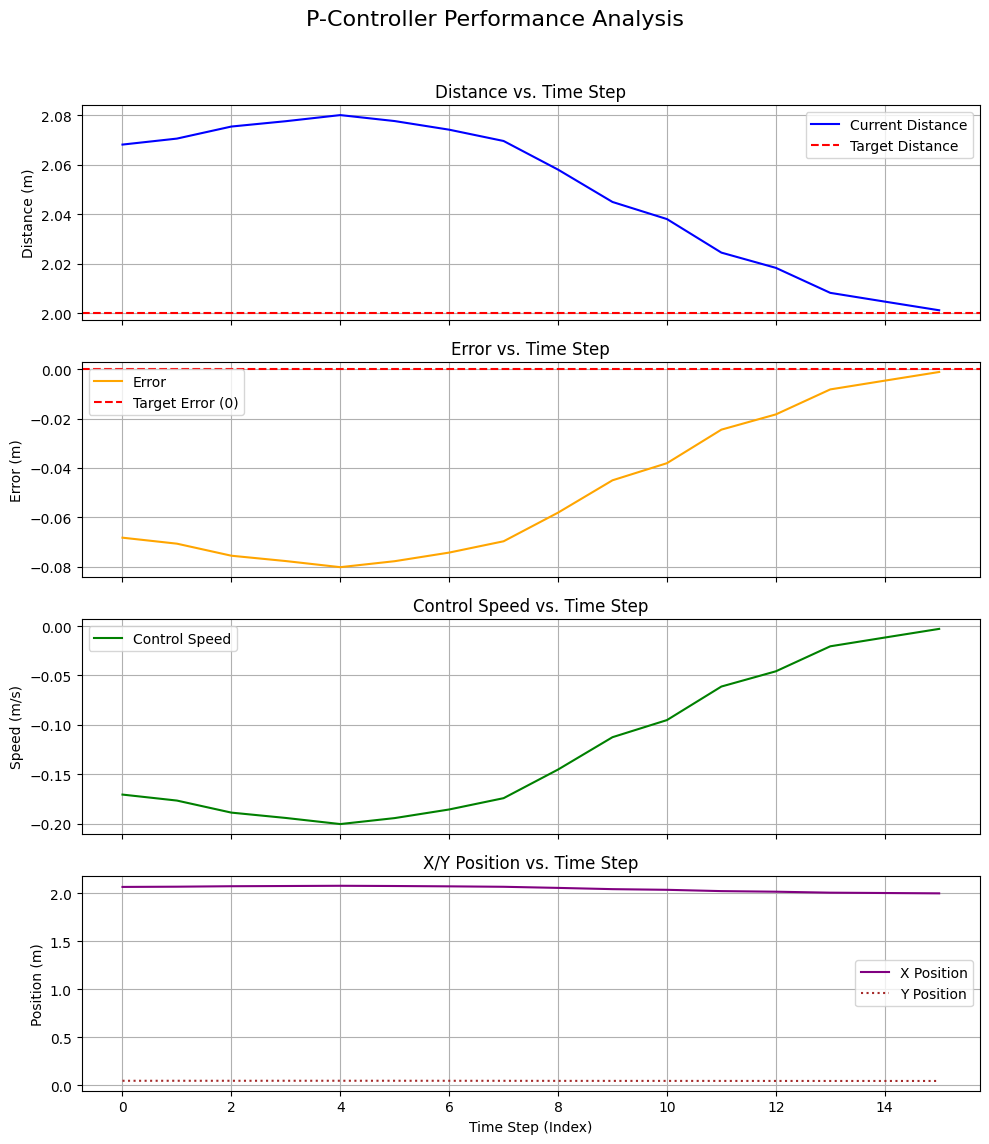

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. อ่านข้อมูลจากไฟล์ CSV ---
try:
    # อ่านไฟล์ CSV ที่เราบันทึกไว้
    df = pd.read_csv("p_controller_log_test.csv")
    print("Successfully loaded p_controller_log.csv")
    print(df.head()) # แสดง 5 แถวแรกเพื่อตรวจสอบ
except FileNotFoundError:
    print("Error: p_controller_log.csv not found. Please run the robot controller script first.")
    exit()

# --- 2. สร้างกราฟ ---

# สร้าง Figure และ Subplots ทั้งหมด 4 กราฟเรียงกันในแนวตั้ง
# figsize=(10, 12) คือขนาดของรูปภาพทั้งหมด (กว้าง 10 นิ้ว, สูง 12 นิ้ว)
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.suptitle('P-Controller Performance Analysis', fontsize=16)

# กราฟที่ 1: ระยะทาง (Distance)
axs[0].plot(df.index, df['current_distance'], label='Current Distance', color='blue')
# เพิ่มเส้นเป้าหมาย
axs[0].axhline(y=df['current_distance'].iloc[-1] + df['error'].iloc[-1], color='r', linestyle='--', label='Target Distance')
axs[0].set_ylabel('Distance (m)')
axs[0].set_title('Distance vs. Time Step')
axs[0].legend()
axs[0].grid(True)

# กราฟที่ 2: ค่าความผิดพลาด (Error)
axs[1].plot(df.index, df['error'], label='Error', color='orange')
axs[1].axhline(y=0, color='r', linestyle='--', label='Target Error (0)')
axs[1].set_ylabel('Error (m)')
axs[1].set_title('Error vs. Time Step')
axs[1].legend()
axs[1].grid(True)

# กราฟที่ 3: ความเร็วที่ใช้ควบคุม (Control Speed)
axs[2].plot(df.index, df['control_speed'], label='Control Speed', color='green')
axs[2].set_ylabel('Speed (m/s)')
axs[2].set_title('Control Speed vs. Time Step')
axs[2].legend()
axs[2].grid(True)

# กราฟที่ 4: ตำแหน่ง X และ Y
axs[3].plot(df.index, df['x_pos'], label='X Position', color='purple')
axs[3].plot(df.index, df['y_pos'], label='Y Position', color='brown', linestyle=':')
axs[3].set_xlabel('Time Step (Index)')
axs[3].set_ylabel('Position (m)')
axs[3].set_title('X/Y Position vs. Time Step')
axs[3].legend()
axs[3].grid(True)

# --- 3. แสดงผลและบันทึกไฟล์ ---
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # ปรับ layout ให้สวยงาม
plt.savefig("controller_performance_plot.png") # บันทึกกราฟเป็นไฟล์รูปภาพ
print("\nGraph has been saved as controller_performance_plot.png")
plt.show() # แสดงกราฟขึ้นมาบนหน้าจอ